# TCSPC Histogram Reconstruction
Here an example how to read the raw data and create the Time-correlated single-photon counting (TCSPC) histogram of each channel.

In [1]:
%pylab inline
import pandas
from tqdm.notebook import tqdm
import h5py
import os
import pandas

Populating the interactive namespace from numpy and matplotlib


Import the BrightEyes-TTM library (`libttp`)

In [2]:
import libttp.ttp as ttp


# Select Data & parameters

In [3]:
filenameToRead="/YOURPATH/YOURFILE.ttr"


In [4]:
CHANNELS=25                              # Number of CHANNELS
sysclk_MHz=240.                          # FPGA system clock (MHz)
laser_MHz=80.                            # Laser repetition rate (MHz)
laser_factor=1                           # Adimensional number to account for laser actual repetiton frequency (default = 1)
list_of_channels = np.arange(0,CHANNELS) # List of channels to analyse (it must be a numpy.array)
kC4=48                                   # Time width of TCSPC histogram bin in [ps] (default = 48ps)

#### Define the output HDF5 filename 

In [5]:
filenameHDF5=filenameToRead+".h5"

## Read the Raw file (protocol v2.0) and create the dataframe

In [6]:
df = ttp.readNewProtocolFileToPandas(
    filenameIn=filenameToRead,
    reorder_channels=True, #needed for 25 channel otherwise the channel will not respect the order
    CHANNELS=CHANNELS,
    force_16bit_step=True)

0 -1
File total size in uint16 units: 149726248
-1
File read size in uint16 units: 149726248
Channels: 25
MAXWORD: 30
28852539
data read
i) added column
ii) added pixel, line, frame
iii) added 'steps' bytes
         assume step 16-bit long
iv) calculate 'step'
Index(['id_0', 'id_1', 'id_2', 'id_3', 'id_4', 'id_5', 'id_6', 'id_7', 'id_8',
       'id_9', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16',
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24',
       'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'valid_tdc_0',
       'valid_tdc_1', 'valid_tdc_2', 'valid_tdc_3', 'valid_tdc_4',
       'valid_tdc_5', 'valid_tdc_6', 'valid_tdc_7', 'valid_tdc_8',
       'valid_tdc_9', 'valid_tdc_10', 'valid_tdc_11', 'valid_tdc_12',
       'valid_tdc_13', 'valid_tdc_14', 'valid_tdc_15', 'valid_tdc_16',
       'valid_tdc_17', 'valid_tdc_18', 'valid_tdc_19', 'valid_tdc_20',
       'valid_tdc_21', 'valid_tdc_22', 'valid_tdc_23', 'valid_tdc_24',
       'valid_dummy

#### Check if any `valid_laser` signals is present

In [7]:
count_L=count_nonzero(df["valid_tdc_L"])
if count_L==0:
    print("No valid_tdc_L found. Check your Laser SYNC.")
else:
    print("valid_tdc_L", count_L)

valid_tdc_L 15440341


#### A quick preview of the total counts on each channel

[[ 308437.  540666.  516823.  482632.  348259.]
 [ 415735.  779450.  972624.  889469.  619580.]
 [ 541080. 1059215. 1378896. 1128908.  671962.]
 [ 495855.  910601. 1220114.  971682.  636053.]
 [ 429716.  573104.  696498.  597887.  426957.]]


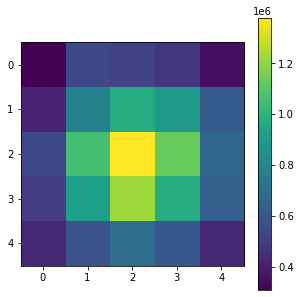

In [8]:
valids=np.zeros(CHANNELS)
for i in range(0,CHANNELS):
    valids[i]=count_nonzero(df["valid_tdc_%d"%i])
if CHANNELS==25:
    figure(figsize(5,5))
    valids=asarray(valids).reshape((5,5))
    imshow(valids)
    colorbar()
elif CHANNELS==49:
    figure(figsize(5,5))
    valids=asarray(valids).reshape((7,7))
    imshow(valids)
    colorbar()

print(valids)


#### Set some useful calculate some useful parameter

In [9]:
laser_MHz=laser_MHz*laser_factor
laser_Hz=laser_MHz*10**6
max_counter=2**16-1
sysclk_ps=1000000./sysclk_MHz #ps
print("SysClk ps:", sysclk_ps)
laser_ps=1000000./laser_MHz #ps
print("LaserClk ps:", laser_ps)
ratio=sysclk_MHz/laser_MHz
sysclk_ps=1e6/sysclk_MHz
laser_ps=1e6/laser_MHz
nbins=int(round(laser_ps/kC4))
print("actual kC4", laser_ps/nbins)

SysClk ps: 4166.666666666667
LaserClk ps: 12500.0
actual kC4 48.07692307692308


# Data frame conversion to H5 format

In [10]:
myReturn=ttp.convertFromPandasDataFrame( df, filenameOutputHDF5=filenameHDF5 ,
                    sysclk_MHz = sysclk_MHz,
                    laser_MHz = laser_MHz,
                    list_of_channels=list_of_channels,
                    compressionLevel=0,
                    ignorePixelLineFrame = False,
                    coincidence_analysis = False,
                    kC4=kC4
                        )

Calculate rates 
Calculate cumulative step 
Add cumulativeStep
Acquisition lasted:  54.083897416666666 s
Scan_enable 9.0 ratio 3.119309642708035e-07 rate 0.16640812570631294
line_enable 37362.0 ratio 0.0012949294096761955 rate 690.8155991821404
pixel_enable 262144.0 ratio 0.009085647855311723 rate 4846.987967239522
Laser 15440341.0 ratio 0.5351467174222246 rate 285488.6895640375
Calculate totalphotons 
start the sum
sum done
kC4<=== 48
sysclk_ps<=== 4166.666666666667
kC4<=== 47.89272030651341
Start process
Start analysisForImg
Arrays copied into analysisForImg


Current frame: 1 	: : 29141025it [00:07, 3758082.68it/s]                                                                                                                                                            


Total Frame: 1
New HDF5 written
total_photon        uint8
cumulative_step     int64
arr_px             uint16
arr_px_corr        uint16
arr_py             uint16
arr_frame          uint16
dtype: object


  0%|                                                                                                                                                                                        | 0/25 [00:00<?, ?it/s]

Start conversion of 0 channel
t_0 valid_tdc_0
..
...



 26%|█████████████████████████████████████████                                                                                                                     | 4081974/15699959 [00:00<00:00, 39890493.91it/s]

starting loop



 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 8477946/15699959 [00:00<00:00, 41294009.31it/s]
15856899it [00:00, 37594754.66it/s]                                                                                                                                                                                 
  4%|███████                                                                                                                                                                         | 1/25 [00:05<02:17,  5.72s/it]

Data ready, conversion to array
Adding keys to HDF5...  "ch_0"
t_0      int16
t_L      int16
dS_0    uint16
dtype: object
Start conversion of 1 channel
t_1 valid_tdc_1
..
...



 29%|█████████████████████████████████████████████▊                                                                                                                | 4602416/15870469 [00:00<00:00, 45799916.10it/s]

starting loop



 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 9204832/15870469 [00:00<00:00, 41030815.39it/s]
16029104it [00:00, 39527287.16it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_1"


  8%|██████████████                                                                                                                                                                  | 2/25 [00:11<02:15,  5.87s/it]

t_1      int16
t_L      int16
dS_1    uint16
dtype: object
Start conversion of 2 channel
t_2 valid_tdc_2
..
...



 27%|██████████████████████████████████████████▋                                                                                                                   | 4287816/15880856 [00:00<00:00, 42688386.52it/s]

starting loop



 54%|█████████████████████████████████████████████████████████████████████████████████████▎                                                                        | 8575632/15880856 [00:00<00:00, 36988001.09it/s]
16039608it [00:00, 37817566.12it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_2"


 12%|█████████████████████                                                                                                                                                           | 3/25 [00:17<02:09,  5.88s/it]

t_2      int16
t_L      int16
dS_2    uint16
dtype: object
Start conversion of 3 channel
t_3 valid_tdc_3
..
...



 26%|█████████████████████████████████████████                                                                                                                     | 4117594/15836904 [00:00<00:00, 40162882.22it/s]

starting loop



 57%|██████████████████████████████████████████████████████████████████████████████████████████                                                                    | 9027033/15836904 [00:00<00:00, 44607584.32it/s]
15995269it [00:00, 45656462.09it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_3"


 16%|████████████████████████████▏                                                                                                                                                   | 4/25 [00:23<02:04,  5.91s/it]

t_3      int16
t_L      int16
dS_3    uint16
dtype: object
Start conversion of 4 channel
t_4 valid_tdc_4
..
...



 33%|████████████████████████████████████████████████████▏                                                                                                         | 5194761/15741734 [00:00<00:00, 49165117.61it/s]

starting loop



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 10232105/15741734 [00:00<00:00, 42105081.67it/s]
15899117it [00:00, 40432183.40it/s]                                                                                                                                                                                 
 20%|███████████████████████████████████▏                                                                                                                                            | 5/25 [00:29<01:56,  5.83s/it]

Data ready, conversion to array
Adding keys to HDF5...  "ch_4"
t_4      int16
t_L      int16
dS_4    uint16
dtype: object
Start conversion of 5 channel
t_5 valid_tdc_5
..
...



 35%|███████████████████████████████████████████████████████▎                                                                                                      | 5521600/15776034 [00:00<00:00, 54894483.51it/s]

starting loop



 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                               | 11043200/15776034 [00:00<00:00, 48336566.85it/s]
15933760it [00:00, 45789138.42it/s]                                                                                                                                                                                 
 24%|██████████████████████████████████████████▏                                                                                                                                     | 6/25 [00:34<01:50,  5.79s/it]

Data ready, conversion to array
Adding keys to HDF5...  "ch_5"
t_5      int16
t_L      int16
dS_5    uint16
dtype: object
Start conversion of 6 channel
t_6 valid_tdc_6
..
...



 22%|██████████████████████████████████▊                                                                                                                           | 3537468/16079496 [00:00<00:00, 35232416.54it/s]

starting loop



 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                   | 10773198/16079496 [00:00<00:00, 35219027.07it/s]
16240194it [00:00, 34091513.87it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_6"


 28%|█████████████████████████████████████████████████▎                                                                                                                              | 7/25 [00:41<01:47,  5.99s/it]

t_6      int16
t_L      int16
dS_6    uint16
dtype: object
Start conversion of 7 channel
t_7 valid_tdc_7
..
...



 17%|██████████████████████████▊                                                                                                                                   | 2753609/16197743 [00:00<00:00, 26283688.45it/s]

starting loop



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 12634206/16197743 [00:00<00:00, 28083186.27it/s]
16359677it [00:00, 27082859.84it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_7"


 32%|████████████████████████████████████████████████████████▎                                                                                                                       | 8/25 [00:48<01:45,  6.23s/it]

t_7      int16
t_L      int16
dS_7    uint16
dtype: object
Start conversion of 8 channel
t_8 valid_tdc_8
..
...



 20%|███████████████████████████████▌                                                                                                                              | 3238080/16190478 [00:00<00:00, 32003289.28it/s]

starting loop



 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                    | 12466608/16190478 [00:00<00:00, 27536470.57it/s]
16352304it [00:00, 29497935.20it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_8"


 36%|███████████████████████████████████████████████████████████████▎                                                                                                                | 9/25 [00:54<01:42,  6.40s/it]

t_8      int16
t_L      int16
dS_8    uint16
dtype: object
Start conversion of 9 channel
t_9 valid_tdc_9
..
...



 28%|████████████████████████████████████████████▏                                                                                                                 | 4465216/15947258 [00:00<00:00, 44097501.16it/s]

starting loop



 56%|████████████████████████████████████████████████████████████████████████████████████████▍                                                                     | 8930432/15947258 [00:00<00:00, 43643416.33it/s]
16106672it [00:00, 36138527.31it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_9"


 40%|██████████████████████████████████████████████████████████████████████                                                                                                         | 10/25 [01:01<01:35,  6.36s/it]

t_9      int16
t_L      int16
dS_9    uint16
dtype: object
Start conversion of 10 channel
t_10 valid_tdc_10
..
...



 23%|████████████████████████████████████▎                                                                                                                         | 3659116/15909226 [00:00<00:00, 36424975.50it/s]

starting loop



 53%|███████████████████████████████████████████████████████████████████████████████████▋                                                                          | 8431876/15909226 [00:00<00:00, 42192966.67it/s]
16068292it [00:00, 37355522.11it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_10"


 44%|█████████████████████████████████████████████████████████████████████████████                                                                                                  | 11/25 [01:07<01:27,  6.28s/it]

t_10      int16
t_L       int16
dS_10    uint16
dtype: object
Start conversion of 11 channel
t_11 valid_tdc_11
..
...



 18%|████████████████████████████▍                                                                                                                                 | 2932002/16288999 [00:00<00:00, 28955881.65it/s]

starting loop



 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                  | 12705342/16288999 [00:00<00:00, 30142383.03it/s]
16451789it [00:00, 30515778.62it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_11"


 48%|████████████████████████████████████████████████████████████████████████████████████                                                                                           | 12/25 [01:13<01:22,  6.35s/it]

t_11      int16
t_L       int16
dS_11    uint16
dtype: object
Start conversion of 12 channel
t_12 valid_tdc_12
..
...



 21%|█████████████████████████████████▏                                                                                                                            | 3455466/16454692 [00:00<00:00, 33307383.34it/s]

starting loop



 79%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                 | 12999134/16454692 [00:00<00:00, 27221070.91it/s]
16619146it [00:00, 26917667.90it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_12"


 52%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                    | 13/25 [01:20<01:17,  6.46s/it]

t_12      int16
t_L       int16
dS_12    uint16
dtype: object
Start conversion of 13 channel
t_13 valid_tdc_13
..
...



 22%|██████████████████████████████████▊                                                                                                                           | 3602346/16374333 [00:00<00:00, 35665167.54it/s]

starting loop



 64%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                        | 10479552/16374333 [00:00<00:00, 30273958.08it/s]
16538043it [00:00, 32204597.84it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_13"


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████                                                                             | 14/25 [01:26<01:11,  6.47s/it]

t_13      int16
t_L       int16
dS_13    uint16
dtype: object
Start conversion of 14 channel
t_14 valid_tdc_14
..
...



 20%|███████████████████████████████▌                                                                                                                              | 3193120/15965691 [00:00<00:00, 31411192.96it/s]

starting loop



 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████                                                       | 10377640/15965691 [00:00<00:00, 32587750.77it/s]
16125256it [00:00, 32117045.26it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_14"


 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                      | 15/25 [01:33<01:03,  6.39s/it]

t_14      int16
t_L       int16
dS_14    uint16
dtype: object
Start conversion of 15 channel
t_15 valid_tdc_15
..
...



 22%|██████████████████████████████████▊                                                                                                                           | 3497230/15896589 [00:00<00:00, 34015285.96it/s]

starting loop



 48%|███████████████████████████████████████████████████████████████████████████▊                                                                                  | 7630320/15896589 [00:00<00:00, 37590573.05it/s]
16055465it [00:00, 36986314.75it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_15"


 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                               | 16/25 [01:39<00:56,  6.31s/it]

t_15      int16
t_L       int16
dS_15    uint16
dtype: object
Start conversion of 16 channel
t_16 valid_tdc_16
..
...



 20%|███████████████████████████████▌                                                                                                                              | 3243820/16219117 [00:00<00:00, 30230361.53it/s]

starting loop



 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                  | 11028988/16219117 [00:00<00:00, 36164468.50it/s]
16381291it [00:00, 36072686.21it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_16"


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                        | 17/25 [01:45<00:50,  6.30s/it]

t_16      int16
t_L       int16
dS_16    uint16
dtype: object
Start conversion of 17 channel
t_17 valid_tdc_17
..
...



 20%|███████████████████████████████▌                                                                                                                              | 3298360/16491883 [00:00<00:00, 31816210.25it/s]


starting loop


 62%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                                                           | 10224916/16491883 [00:00<00:00, 33370466.30it/s]
16656718it [00:00, 33007466.22it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_17"


 72%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                 | 18/25 [01:51<00:44,  6.33s/it]

t_17      int16
t_L       int16
dS_17    uint16
dtype: object
Start conversion of 18 channel
t_18 valid_tdc_18
..
...



 25%|███████████████████████████████████████▍                                                                                                                      | 4074175/16296786 [00:00<00:00, 39155246.60it/s]

starting loop



 71%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 11570657/16296786 [00:00<00:00, 31554136.74it/s]
16459667it [00:00, 31026499.63it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_18"


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                          | 19/25 [01:58<00:38,  6.35s/it]

t_18      int16
t_L       int16
dS_18    uint16
dtype: object
Start conversion of 19 channel
t_19 valid_tdc_19
..
...



 29%|█████████████████████████████████████████████▊                                                                                                                | 4639333/15997721 [00:00<00:00, 46201268.26it/s]


starting loop


 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 9278666/15997721 [00:00<00:00, 45171589.71it/s]
16157677it [00:00, 40574938.14it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_19"


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                   | 20/25 [02:04<00:31,  6.26s/it]

t_19      int16
t_L       int16
dS_19    uint16
dtype: object
Start conversion of 20 channel
t_20 valid_tdc_20
..
...



 35%|███████████████████████████████████████████████████████▎                                                                                                      | 5528215/15794983 [00:00<00:00, 54466945.15it/s]

starting loop



15952849it [00:00, 49343849.21it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_20"


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                            | 21/25 [02:10<00:24,  6.10s/it]

t_20      int16
t_L       int16
dS_20    uint16
dtype: object
Start conversion of 21 channel
t_21 valid_tdc_21
..
...



 26%|█████████████████████████████████████████                                                                                                                     | 4145258/15943376 [00:00<00:00, 39829817.74it/s]

starting loop



 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 8768815/15943376 [00:00<00:00, 43265778.85it/s]
16102733it [00:00, 40539583.82it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_21"


 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                     | 22/25 [02:15<00:18,  6.02s/it]

t_21      int16
t_L       int16
dS_21    uint16
dtype: object
Start conversion of 22 channel
t_22 valid_tdc_22
..
...



 25%|███████████████████████████████████████▍                                                                                                                      | 4008375/16033563 [00:00<00:00, 39958794.93it/s]

starting loop



 72%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 11544120/16033563 [00:00<00:00, 32420021.85it/s]
16193835it [00:00, 33370984.51it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_22"


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 23/25 [02:21<00:12,  6.02s/it]

t_22      int16
t_L       int16
dS_22    uint16
dtype: object
Start conversion of 23 channel
t_23 valid_tdc_23
..
...



 26%|█████████████████████████████████████████                                                                                                                     | 4145440/15944021 [00:00<00:00, 40757415.15it/s]

starting loop



 55%|██████████████████████████████████████████████████████████████████████████████████████▉                                                                       | 8769200/15944021 [00:00<00:00, 43129053.91it/s]
16103440it [00:00, 36550635.15it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_23"


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 24/25 [02:27<00:06,  6.01s/it]

t_23      int16
t_L       int16
dS_23    uint16
dtype: object
Start conversion of 24 channel
t_24 valid_tdc_24
..
...



 29%|█████████████████████████████████████████████▊                                                                                                                | 4538848/15651238 [00:00<00:00, 44860905.22it/s]

starting loop



 58%|███████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 9077696/15651238 [00:00<00:00, 44322097.92it/s]
15807712it [00:00, 40655262.14it/s]                                                                                                                                                                                 


Data ready, conversion to array
Adding keys to HDF5...  "ch_24"


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [02:33<00:00,  6.15s/it]

t_24      int16
t_L       int16
dS_24    uint16
dtype: object
Data saved:  /home/mdonato/Downloads/14_zoom_FOV15_512x512_200us.ttr.h5


## Timing calibration of data

In [11]:
calibDict,list_of_channels_calibrated = ttp.calculateCalibFromH5(filenameH5=myReturn['filenameH5'],   # the HDF5 file input
                                                                 listChannel=list_of_channels,      # list of channel [0,mchannel]
                                                                 return_numeric_channels=True)        # to activate the list_of_channels_calibrated

  0%|                                                                                                                                                                                        | 0/25 [00:02<?, ?it/s]


ch_L calculated from ch_0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [01:11<00:00,  2.85s/it]


In [12]:
table_channels={}
for i in tqdm(list_of_channels_calibrated):
    table_channels[i] = ttp.applyCalibDict(myReturn['filenameH5'],
                        channel=i, 
                        calibDict=calibDict)

  0%|          | 0/25 [00:00<?, ?it/s]

# TCSPC Histograms processing

In [13]:
dt_mod={}

for i in tqdm(list_of_channels_calibrated):
    df = table_channels[i]
    dt_mod[i] = np.mod(laser_ps-df['dt_'+str(i)],laser_ps) # flip and 

  0%|          | 0/25 [00:00<?, ?it/s]

# TCSPC Histograms plots

### The histograms are calculated with data after the autocalibration

In [14]:
xhist_calib={}
yhist_calib={}
nbins=int(round(laser_ps/kC4))

for k in tqdm(list_of_channels_calibrated):
    yhist_calib[k],xhist_calib[k]=histogram(dt_mod[k], range=[0,laser_ps],bins=nbins)

  0%|          | 0/25 [00:00<?, ?it/s]

### The histograms are calculated with data after by using a fixed-value calibration factor (kC4)

In [15]:

xhist_not_calib={}
yhist_not_calib={}
nbins=int(round(laser_ps/kC4))

for k in tqdm(list_of_channels_calibrated):
    t_L  = table_channels[k]["t_L"]
    t_CH = table_channels[k]["t_%d"%k]
    dS_0  = table_channels[k]["dS_%d"%k]
    dt_notCalib=dS_0*sysclk_ps-(t_L-t_CH)*kC4
    dt_mod_notCalib=np.mod(laser_ps-dt_notCalib, laser_ps) #apply flip and modulo
    yhist_not_calib[k],xhist_not_calib[k]=histogram(dt_mod_notCalib, range=[0,laser_ps],bins=nbins)

  0%|          | 0/25 [00:00<?, ?it/s]

### The plot with comparison of data "autocalibrated" and data "fixed-value calibration"

  0%|          | 0/25 [00:00<?, ?it/s]

/tmp/ipykernel_287378/3111564732.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure(figsize(16,3))


<Figure size 1152x216 with 0 Axes>

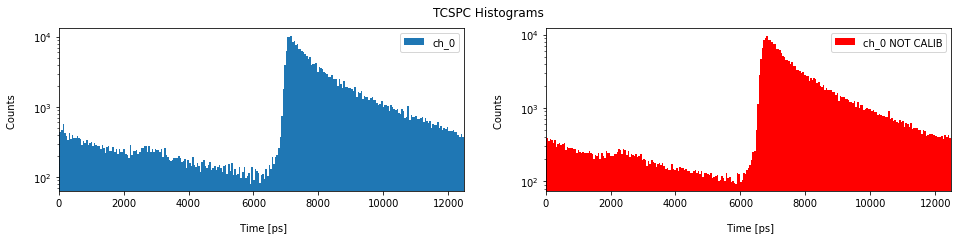

<Figure size 1152x216 with 0 Axes>

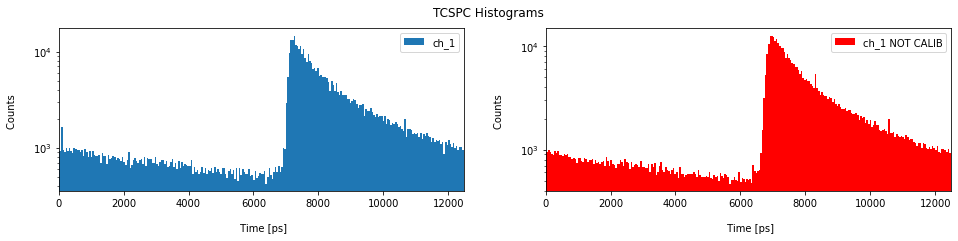

<Figure size 1152x216 with 0 Axes>

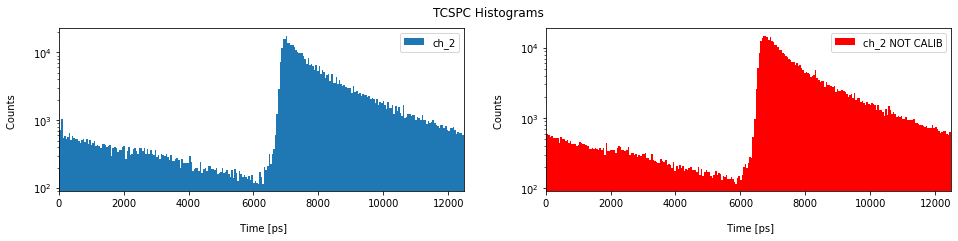

<Figure size 1152x216 with 0 Axes>

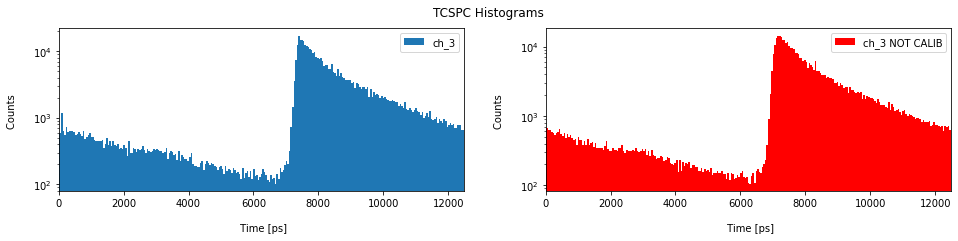

<Figure size 1152x216 with 0 Axes>

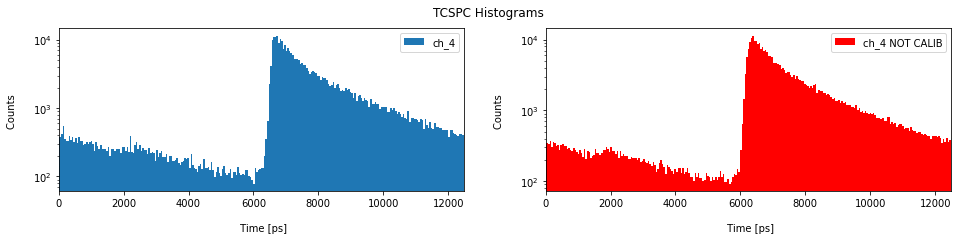

<Figure size 1152x216 with 0 Axes>

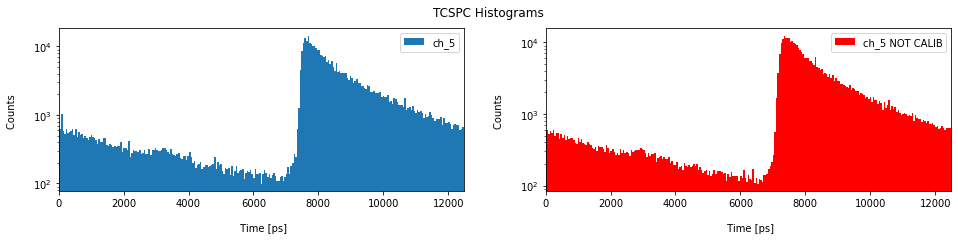

<Figure size 1152x216 with 0 Axes>

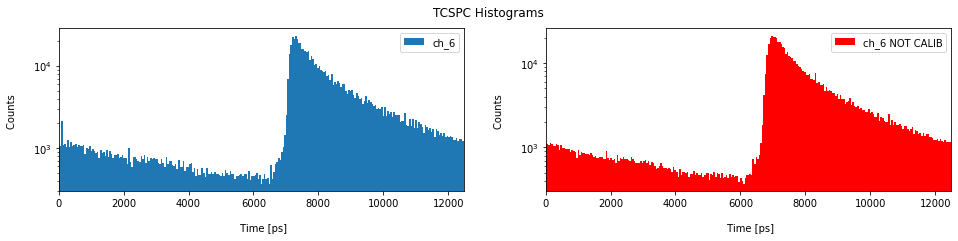

<Figure size 1152x216 with 0 Axes>

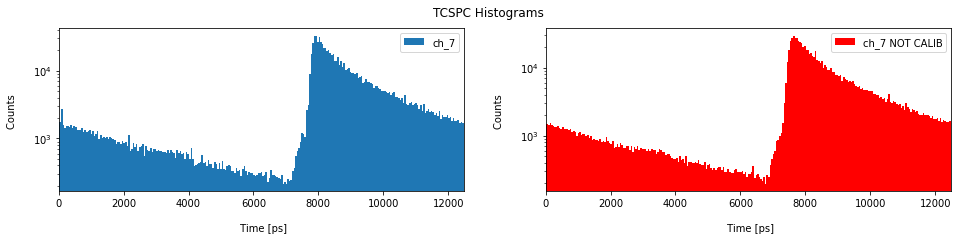

<Figure size 1152x216 with 0 Axes>

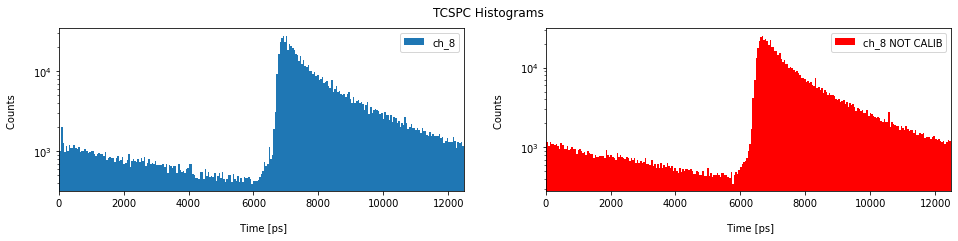

<Figure size 1152x216 with 0 Axes>

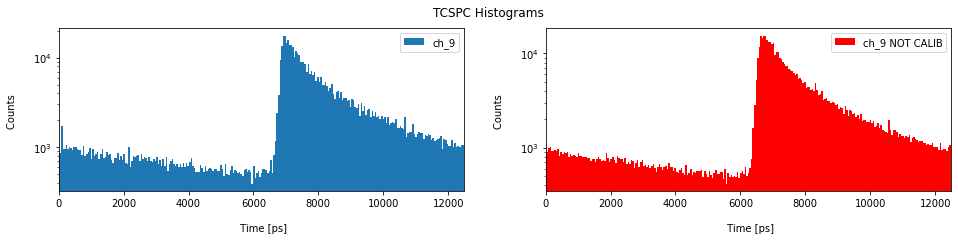

<Figure size 1152x216 with 0 Axes>

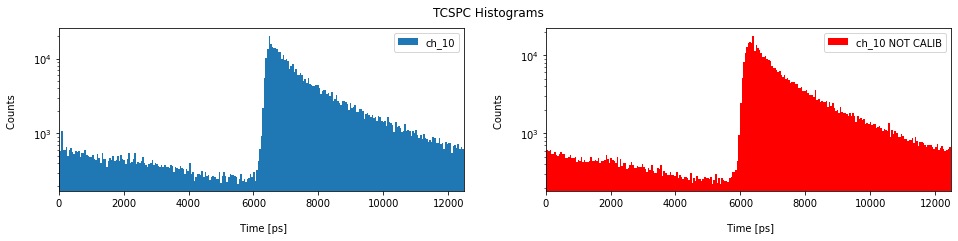

<Figure size 1152x216 with 0 Axes>

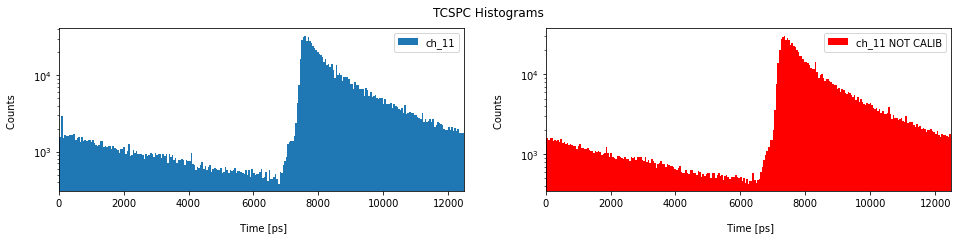

<Figure size 1152x216 with 0 Axes>

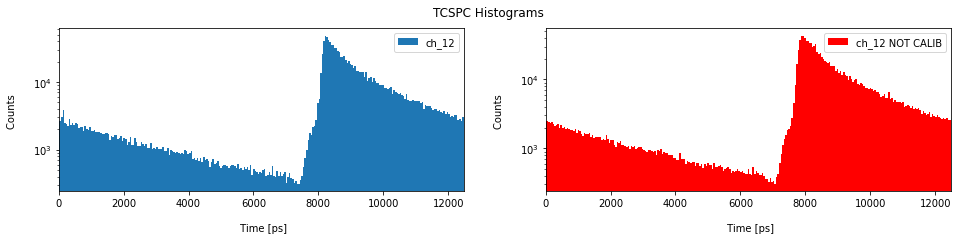

<Figure size 1152x216 with 0 Axes>

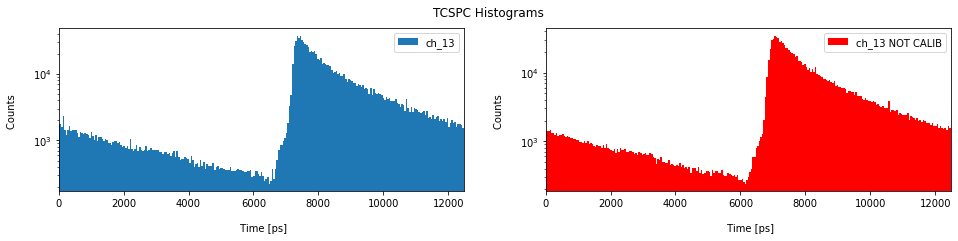

<Figure size 1152x216 with 0 Axes>

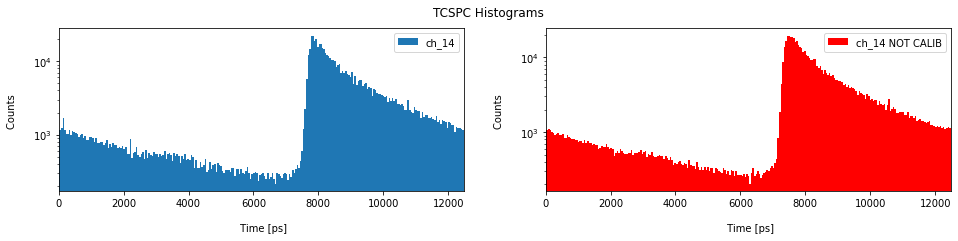

<Figure size 1152x216 with 0 Axes>

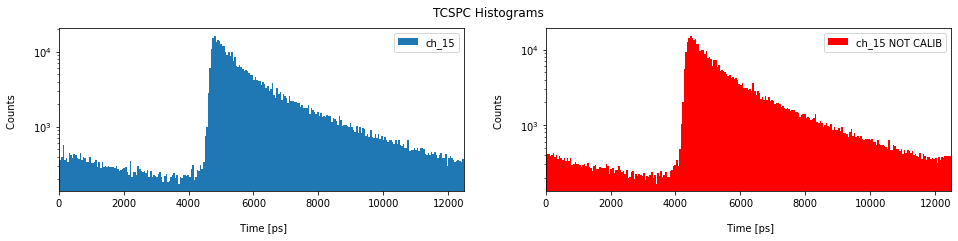

<Figure size 1152x216 with 0 Axes>

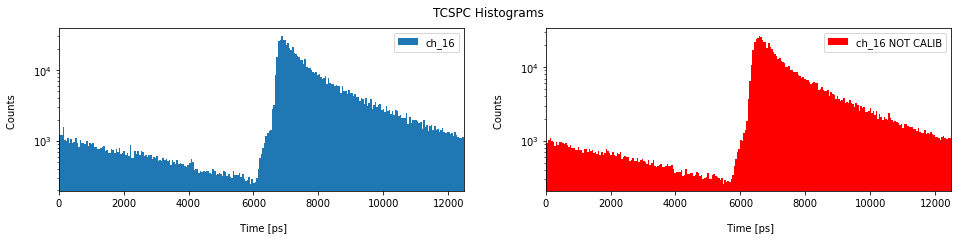

<Figure size 1152x216 with 0 Axes>

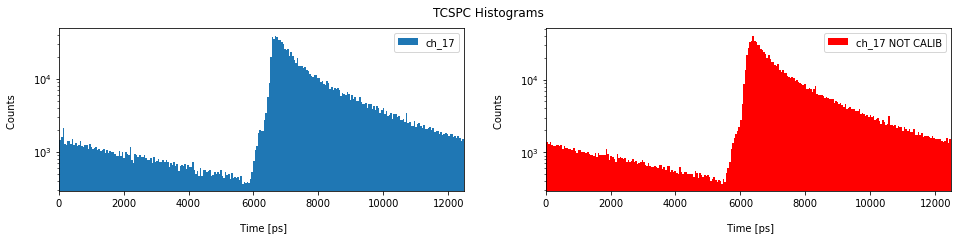

<Figure size 1152x216 with 0 Axes>

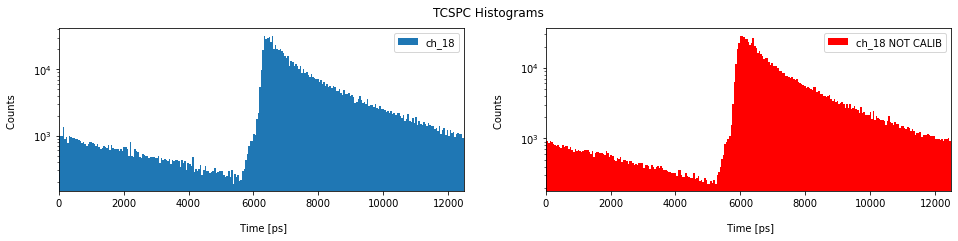

<Figure size 1152x216 with 0 Axes>

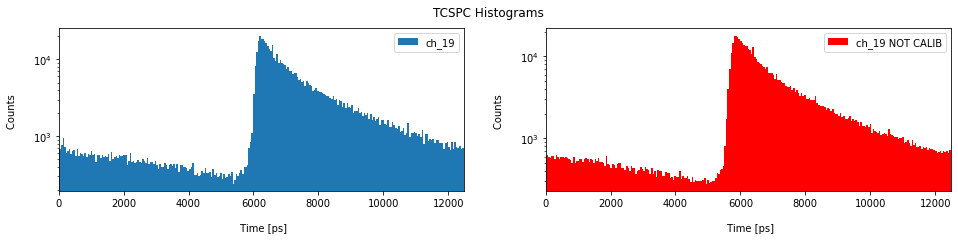

<Figure size 1152x216 with 0 Axes>

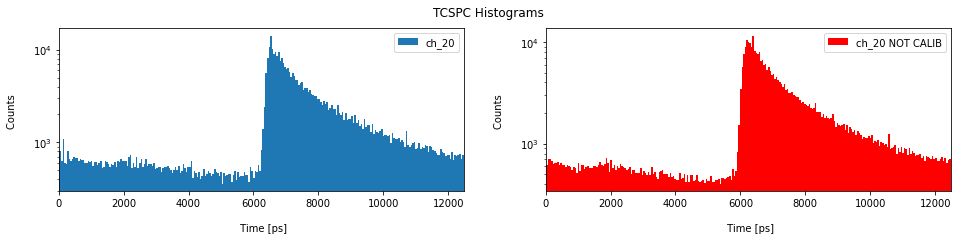

<Figure size 1152x216 with 0 Axes>

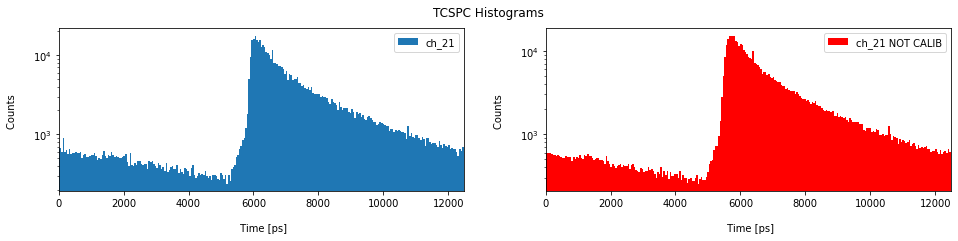

<Figure size 1152x216 with 0 Axes>

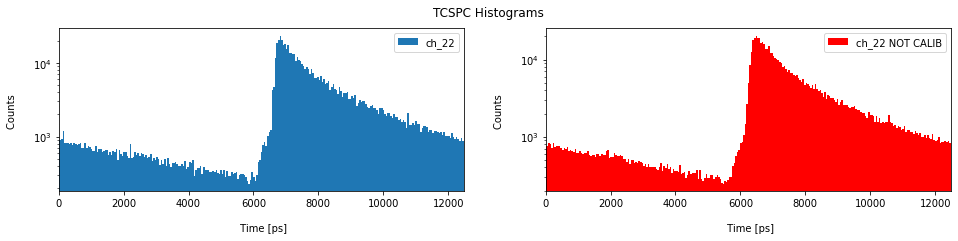

<Figure size 1152x216 with 0 Axes>

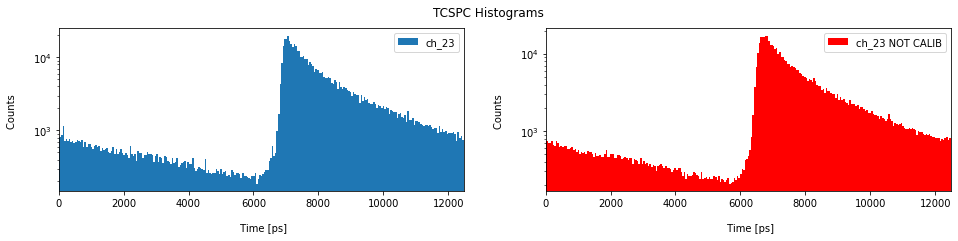

<Figure size 1152x216 with 0 Axes>

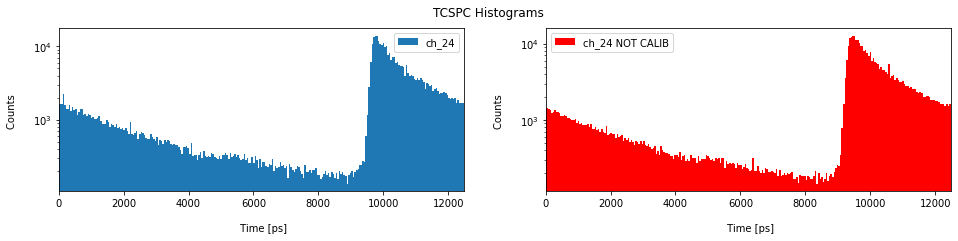

In [16]:
for k in tqdm(list_of_channels_calibrated):
    figure(figsize(16,3))
    fig, (ax1, ax2) = plt.subplots(1, 2)    
    ax1.bar(xhist_calib[k][:-1],
            yhist_calib[k][:],
            width=xhist_calib[k][1]-xhist_calib[k][0],
            label='ch_%d'%k)        
    ax2.bar(xhist_not_calib[k][:-1],
            yhist_not_calib[k],
            width=xhist_calib[k][1]-xhist_calib[k][0],
            label='ch_%d NOT CALIB'%k,
            color="r")  
    ax1.set_yscale("log")    
    ax2.set_yscale("log")    
    ax1.legend()
    ax2.legend()
    fig.suptitle('TCSPC Histograms \n')
    ax1.set_xlim(0,laser_ps)
    ax2.set_xlim(0,laser_ps)
    ax1.set_xlabel('\n Time [ps]')
    ax2.set_xlabel('\n Time [ps]')
    ax1.set_ylabel('Counts \n')
    ax2.set_ylabel('Counts \n')